In [15]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm  # Use tqdm.notebook.tqdm in Jupyter Notebook
import cv2
from scipy import stats
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report, precision_score, recall_score
)
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Ensure plots are displayed inline
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf

# GPU Check (Remove if not using GPU)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found, using CPU instead.")
else:
    print('Found GPU at:', device_name)

# Print TensorFlow Version
print("TensorFlow Version:", tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
)
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions


GPU not found, using CPU instead.
TensorFlow Version: 2.18.0


# Loading the dataset

In [16]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = []  
    target = []  # Store labels separately
    valid_extensions = (".jpg", ".jpeg", ".png")  # Only allow image files

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # Convert label to integer

        for img in os.listdir(path):
            if not img.lower().endswith(valid_extensions):  # Skip non-image files
                print(f"Skipping non-image file: {img}")
                continue  
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                if img_arr is None:  # Check if the image is valid
                    print(f"Skipping unreadable image: {img}")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize to fixed size
                data.append(resized_arr)  # Append image only
                target.append(class_num)  # Append label separately
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    return np.array(data, dtype=np.float32), np.array(target, dtype=np.int32)  # Convert separately

In [17]:
# Load the datasets
train_data, train_labels = get_data('chest_xray/chest_xray/train')
test_data, test_labels = get_data('chest_xray/chest_xray/test')
val_data, val_labels = get_data('chest_xray/chest_xray/val')

print(f"Train Data Shape: {train_data.shape}, Train Labels Shape: {train_labels.shape}")

Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store
Train Data Shape: (5216, 150, 150), Train Labels Shape: (5216,)


# Data Visualization and Preprocessing

In [18]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

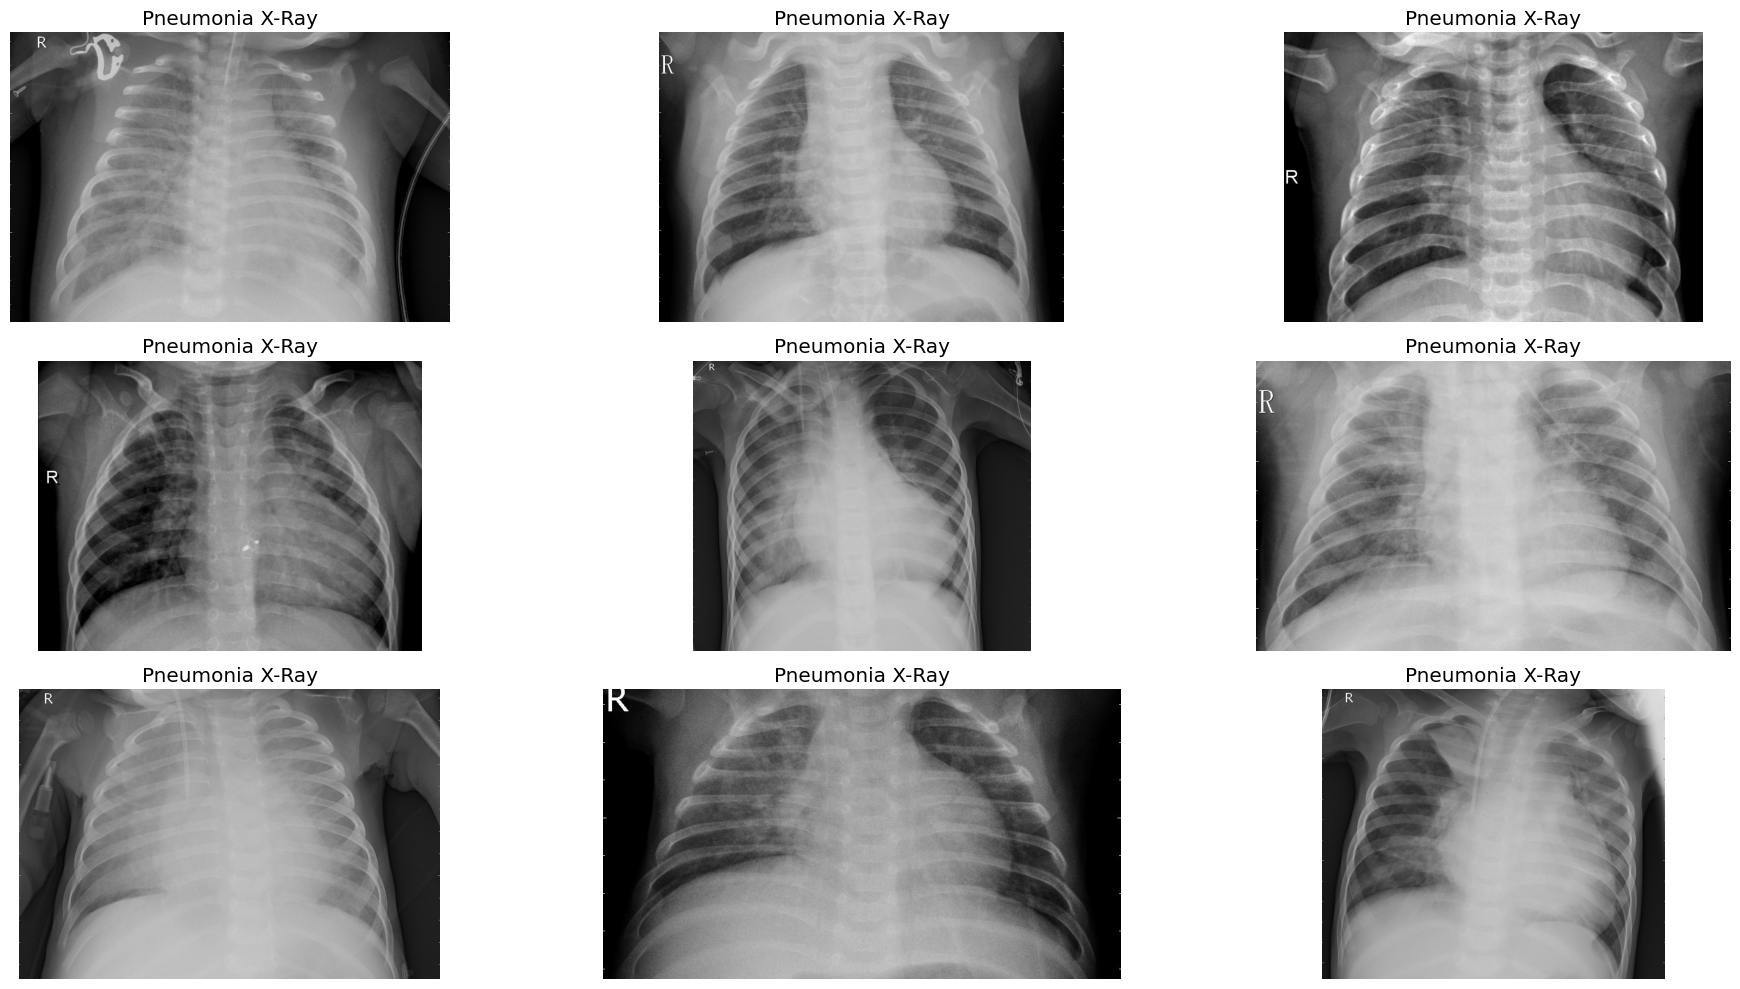

In [19]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()
plt.savefig("outputs/pneumonia_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

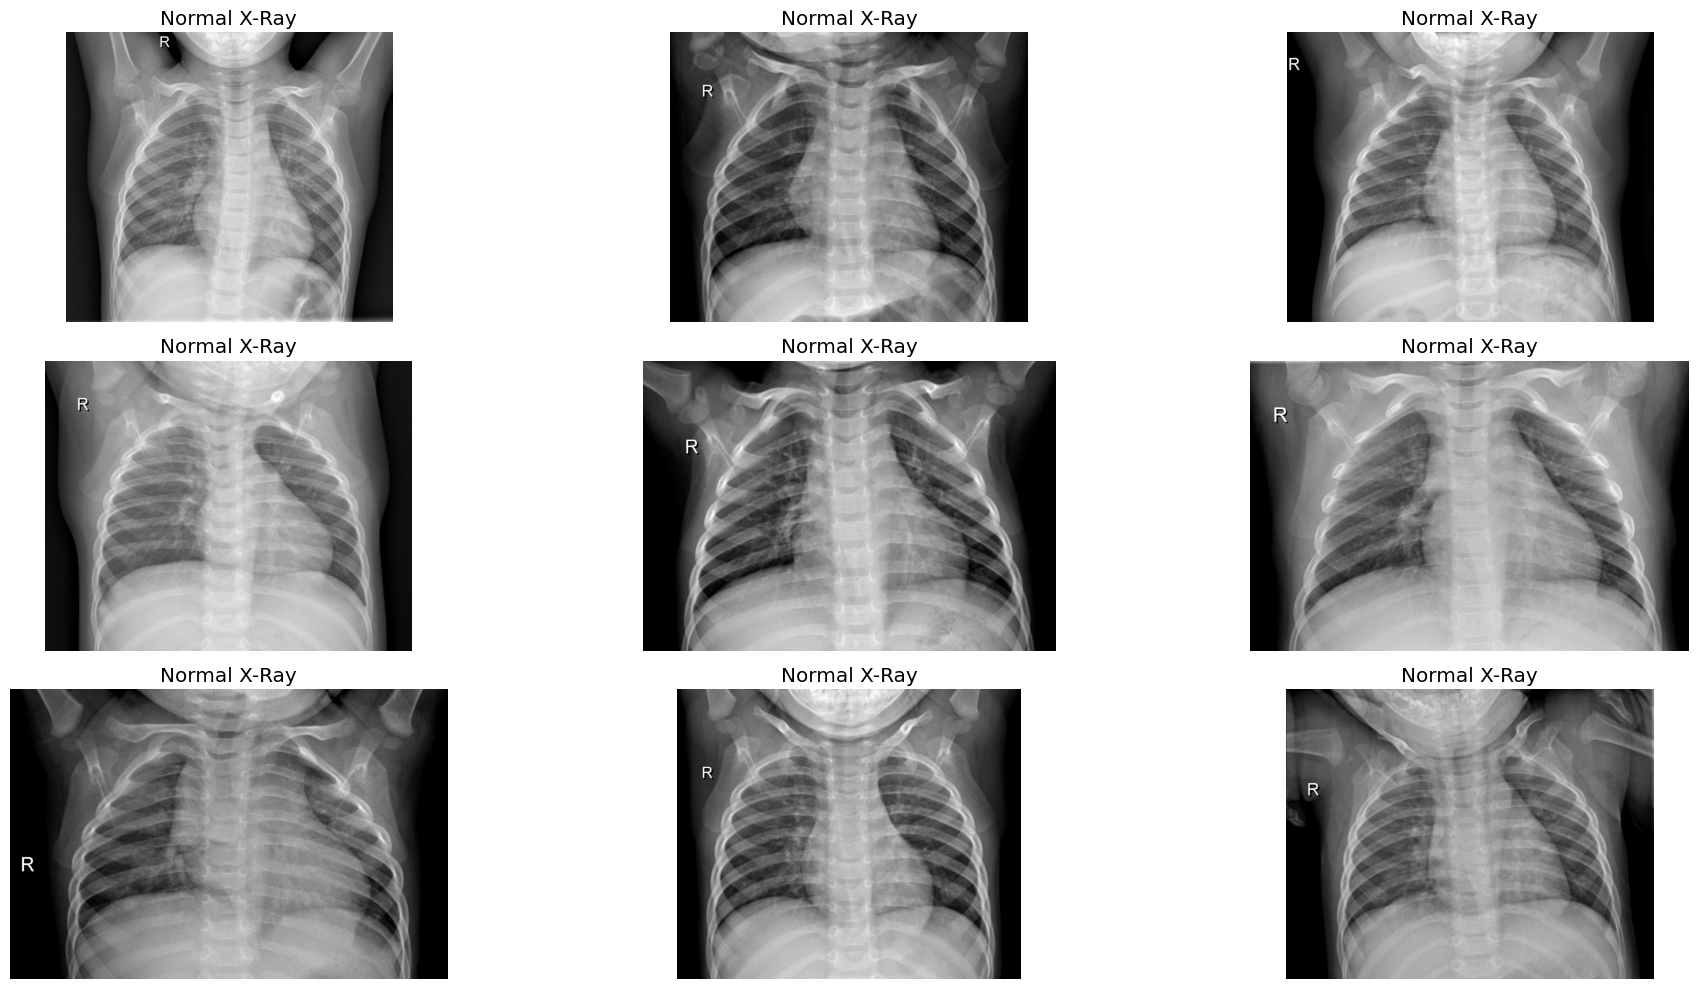

In [20]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()
plt.savefig("outputs/normal_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

Text(0.5, 1.0, 'NORMAL')

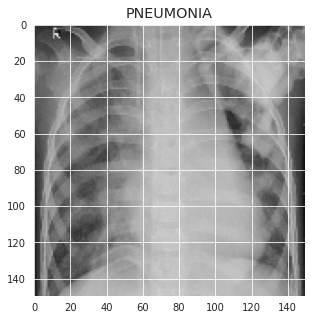

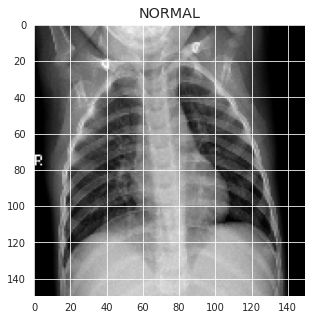

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [27]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
valid_dir = "chest_xray/val/"


normal_train = os.listdir("chest_xray/train/NORMAL")
normal_train_dir = "chest_xray/train/NORMAL"
normal_val = os.listdir("chest_xray/val/NORMAL")
normal_val_dir = "chest_xray/val/NORMAL"
normal_test = os.listdir("chest_xray/test/NORMAL")
normal_test_dir = "chest_xray/test/NORMAL"

pneumonia_train = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_train_dir = "chest_xray/train/PNEUMONIA"
pneumonia_val = os.listdir("chest_xray/val/PNEUMONIA")
pneumonia_val_dir = "chest_xray/val/PNEUMONIA"
pneumonia_test = os.listdir("chest_xray/test/PNEUMONIA")
pneumonia_test_dir = "chest_xray/test/PNEUMONIA"

In [28]:
print("{} Infected training images:".format(len(os.listdir(pneumonia_train_dir))))
print("{} Normal training images:".format(len(os.listdir(normal_train_dir))))
print(" {} Infected valid images:".format(len(os.listdir(pneumonia_val_dir))))
print(" {} Normal valid images:".format(len(os.listdir(normal_val_dir))))
print(" {} Infected testing images:".format(len(os.listdir(pneumonia_test_dir))))
print(" {} Normal testing images:".format(len(os.listdir(normal_test_dir))))

3875 Infected training images:
1341 Normal training images:
 8 Infected valid images:
 8 Normal valid images:
 390 Infected testing images:
 234 Normal testing images:


In [29]:
# Train
infected_trn_fpaths = [os.path.join(pneumonia_train_dir, fpath) for fpath in os.listdir(pneumonia_train_dir)]
healthy_trn_fpaths = [os.path.join(normal_train_dir, fpath) for fpath in os.listdir(normal_train_dir)]

# Valid
infected_valid_fpaths = [os.path.join(pneumonia_val_dir, fpath) for fpath in os.listdir(pneumonia_val_dir)]
healthy_valid_fpaths = [os.path.join(normal_val_dir, fpath) for fpath in os.listdir(normal_val_dir)]

# Test
infected_test_fpaths = [os.path.join(pneumonia_test_dir, fpath) for fpath in os.listdir(pneumonia_test_dir)]
healthy_test_fpaths = [os.path.join(normal_test_dir, fpath) for fpath in os.listdir(normal_test_dir)]

In [30]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 5215


In [31]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [127 384   3]
Avg Dimensions:           [ 968.07476994 1320.61081288    3.        ]
Median Dimensions:        [ 888. 1284.    3.]
Most Frequent Dimensions: [ 736 1008    3]
Max Dimensions:           [2663 2916    3]


In [32]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

# Data augmentation and resizing images

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [34]:
class_labels, class_names

({'NORMAL': 0, 'PNEUMONIA': 1}, {0: 'NORMAL', 1: 'PNEUMONIA'})

# Transfer Learning - VGG19 CNN Architecture

In [35]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'models/pneumonia.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

c:\Program Files\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [36]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=20,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


c:\Program Files\Python311\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6618 - loss: 0.6450
Epoch 1: val_loss improved from inf to 0.57340, saving model to models/pneumonia.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.6630 - loss: 0.6436 - val_accuracy: 0.8125 - val_loss: 0.5734 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7516 - loss: 0.4983
Epoch 2: val_loss improved from 0.57340 to 0.54451, saving model to models/pneumonia.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7517 - loss: 0.4981 - val_accuracy: 0.7500 - val_loss: 0.5445 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7790 - loss: 0.4390
Epoch 3: val_loss improved from 0.54451 to 0.52703, saving model to models/pneumonia.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7791 - loss: 0.4389 - val_accuracy: 0.7500 - val_loss: 0.5270 - learning_rate: 1.0000e-04
Epoch 4/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8557 - loss: 0.3566

c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss did not improve from 0.52703
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 428ms/step - accuracy: 0.8326 - loss: 0.3798 - val_accuracy: 0.6250 - val_loss: 0.5708 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8014 - loss: 0.4247
Epoch 5: val_loss improved from 0.52703 to 0.50793, saving model to models/pneumonia.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8015 - loss: 0.4245 - val_accuracy: 0.7500 - val_loss: 0.5079 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8077 - loss: 0.4173
Epoch 6: val_loss did not improve from 0.50793
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8079 - loss: 0.4169 - val_accuracy: 0.6250 - val_loss: 0.5671 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8034 - loss: 0.4073
Epoch 7: val_loss did not improve from 0.50793
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.8038 - loss: 0.4069 - val_accuracy: 0.7500 - val_loss: 0.5300 - learning_rate: 1.0000e-04
Epoch 8/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.8290 - loss: 0.3880
Epoch 8: val_loss improved from 0.50793 to 0.42294, saving model to models/pneumonia.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 580ms/step - accuracy: 0.8239 - loss: 0.3912 - val_accuracy: 0.8125 - val_loss: 0.4229 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8311 - loss: 0.3700
Epoch 9: val_loss did not improve from 0.42294
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8311 - loss: 0.3698 - val_accuracy: 0.7500 - val_loss: 0.5275 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8382 - loss: 0.3708
Epoch 10: val_loss did not improve from 0.42294
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8381 - loss: 0.3709 - val_accuracy: 0.8125 - val_loss: 0.4522 - learning_rate: 1.0000e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8274 - loss: 0.3876
Epoch 11: val_loss did not improve from 0.42294
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8276 - loss: 0.3873 - val_accuracy: 0.8125 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 12/20
13/50 ━━━━━━━━━━

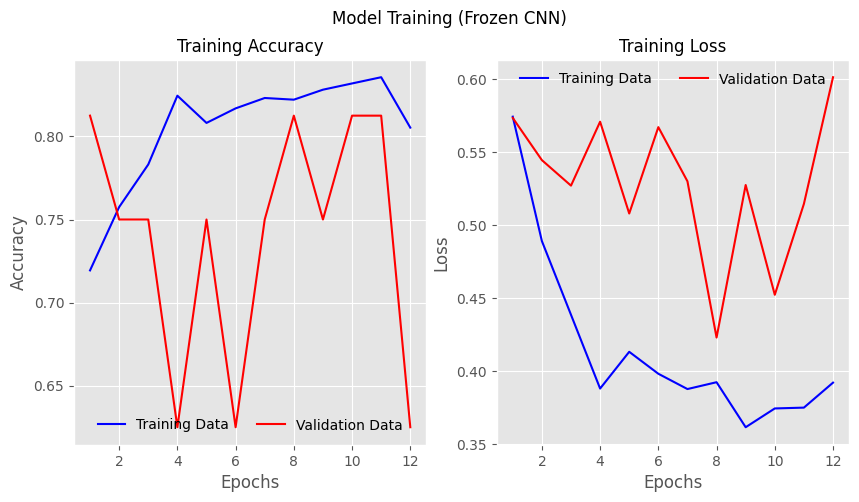

In [37]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/pneumonia_training_frozencnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [56]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure the models directory exists
if not os.path.isdir('models/'):
    os.mkdir('models/')

# Save the entire model (architecture + weights)
model_01.save("models/malaria.h5")  

# Load the saved model correctly
model_01 = load_model("models/malaria.h5")  # Use this instead of load_weights

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Resize test images and generate batches
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=False,
    seed=42,
    color_mode='rgb'
)

# Evaluate the model on validation and test datasets
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

Found 624 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6250 - loss: 0.6013


c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.6037 - loss: 0.7126


In [57]:
# Print evaluation results
print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))


Validation loss:     0.6013
Validation accuracy: 0.6250
Test loss:           0.4650
Test accuracy:       0.7772


In [58]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

624/624 ━━━━━━━━━━━━━━━━━━━━ 84s 133ms/step


In [59]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['NORMAL', 'PNEUMONIA']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])

              precision    recall  f1-score   support

      NORMAL       0.91      0.45      0.60       234
   PNEUMONIA       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624



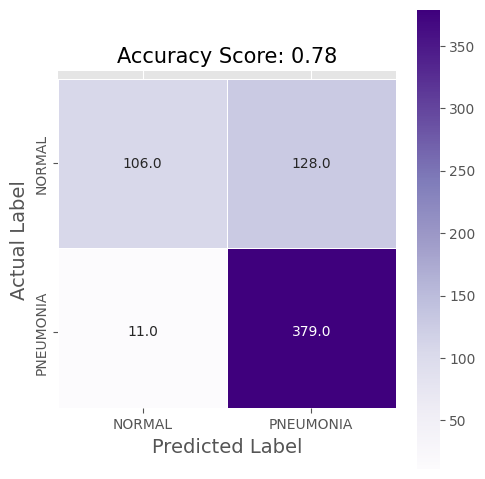

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

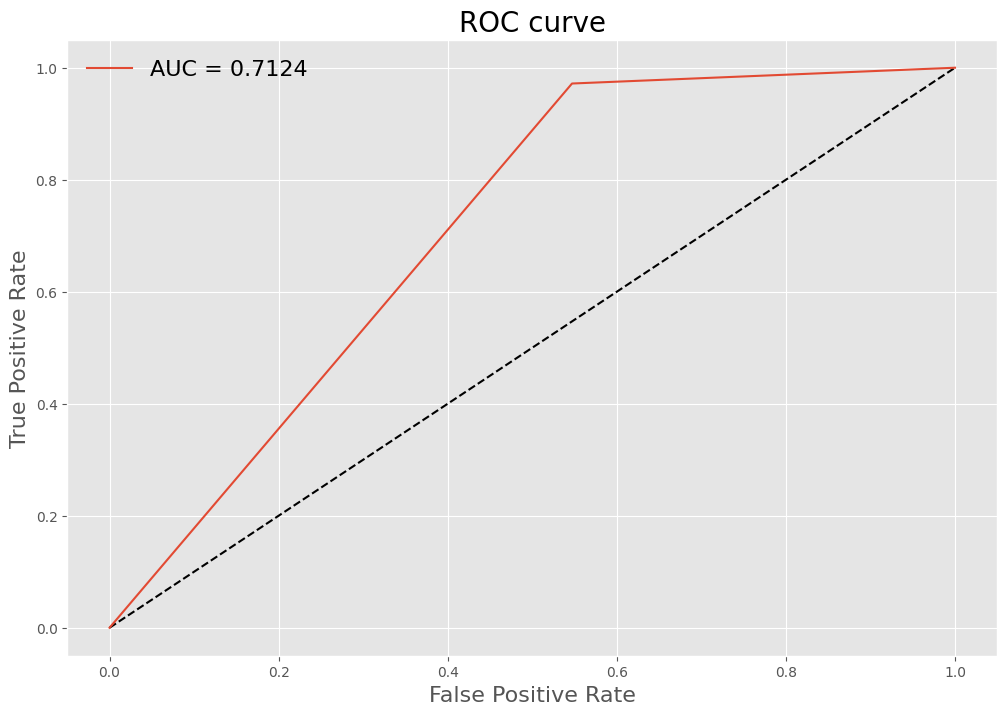

In [61]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Incremental unfreezing and fine-tuning

In [62]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [63]:
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

c:\Program Files\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [65]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8726 - loss: 0.2778
Epoch 1: val_loss did not improve from 0.35231
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8740 - loss: 0.2753 - val_accuracy: 0.8125 - val_loss: 0.5220 - learning_rate: 5.0000e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8831 - loss: 0.2800
Epoch 2: val_loss did not improve from 0.35231
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8827 - loss: 0.2800 - val_accuracy: 0.8125 - val_loss: 0.4246 - learning_rate: 5.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8919 - loss: 0.2618
Epoch 3: val_loss did not improve from 0.35231
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8930 - loss: 0.2604 - val_accuracy: 0.8125 - val_loss: 0.4766 - learning_rate: 5.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8579 - loss: 0.3098
Epoch 4: val_loss did not improve from 0.35231

Epoch 4: ReduceLROnPlateau reducing learning rate 

In [71]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Ensure models directory exists
if not os.path.isdir('models/'):
    os.mkdir('models/')

# Save the entire model (architecture + weights)
model_02.save("models/vgg19_model_02.h5")

# Evaluating the model

Found 624 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 0.6235


c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.7795 - loss: 0.5547
Validation loss:     0.6235
Validation accuracy: 0.7500
Test loss:           0.3696
Test accuracy:       0.8542
624/624 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



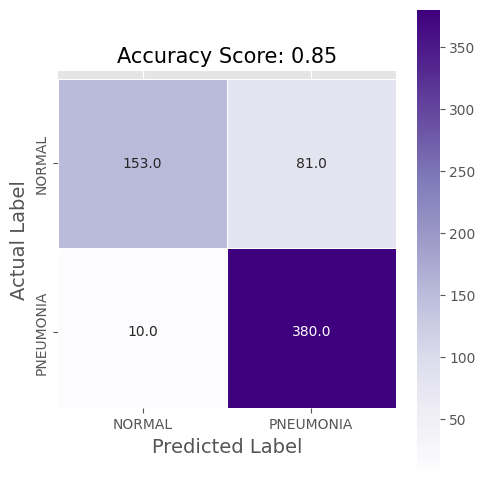

In [72]:
# Load the saved model correctly
model_02 = load_model("models/vgg19_model_02.h5")

# Preprocess validation and test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=False,
    seed=42,
    color_mode='rgb'
)

# Evaluate the model on validation and test datasets
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {:.4f}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {:.4f}'.format(vgg_val_eval_02[1]))
print('Test loss:           {:.4f}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {:.4f}'.format(vgg_test_eval_02[1]))

# Get filenames and number of samples
filenames = test_generator.filenames
nb_samples = len(filenames)

# Predict test data
vgg_predictions_02 = model_02.predict(test_generator, steps=nb_samples, verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)

# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix
vgg_conf_mat_02 = pd.DataFrame(
    confusion_matrix(test_generator.classes, vgg_pred_labels_02),
    index=['NORMAL', 'PNEUMONIA'],
    columns=['NORMAL', 'PNEUMONIA']
)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_title(f"Accuracy Score: {vgg_test_eval_02[1]:.2f}", size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()
plt.show()


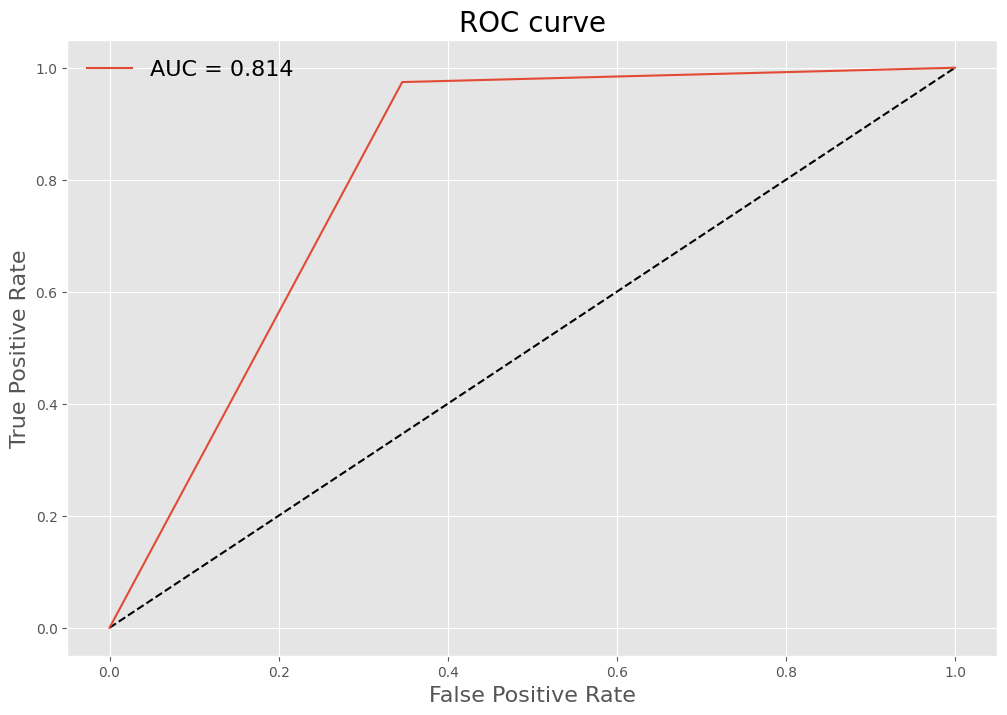

In [79]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Unfreezing and fine-tuning the entire network[link text

In [80]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

# Build the network
base_model = VGG19(include_top=False, input_shape=(128, 128, 3))
x = base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_03 = Model(inputs=base_model.input, outputs=output)

# ✅ **Correct way to load the pre-trained model**
model_03 = load_model('models/vgg19_model_02.h5')  # Corrected ✅

# Set optimizer
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


c:\Program Files\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [81]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8925 - loss: 0.2582
Epoch 1: val_loss did not improve from 0.35231
100/100 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8926 - loss: 0.2581 - val_accuracy: 0.7500 - val_loss: 0.6115 - learning_rate: 1.0000e-04
Epoch 2/35
 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8985 - loss: 0.2420

c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.35231
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8999 - loss: 0.2406 - val_accuracy: 0.8125 - val_loss: 0.5598 - learning_rate: 1.0000e-04
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9050 - loss: 0.2374
Epoch 3: val_loss did not improve from 0.35231
100/100 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9050 - loss: 0.2373 - val_accuracy: 0.6875 - val_loss: 0.7723 - learning_rate: 1.0000e-04
Epoch 4/35
 63/100 ━━━━━━━━━━━━━━━━━━━━ 29s 810ms/step - accuracy: 0.9072 - loss: 0.2278
Epoch 4: val_loss did not improve from 0.35231
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 512ms/step - accuracy: 0.9074 - loss: 0.2252 - val_accuracy: 0.7500 - val_loss: 0.6511 - learning_rate: 1.0000e-04
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9007 - loss: 0.2303
Epoch 5: val_loss did not improve from 0.35231
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 796ms/step - accuracy: 0.9008 - loss: 0.2303 - val_accuracy: 0.6875 - val_lo

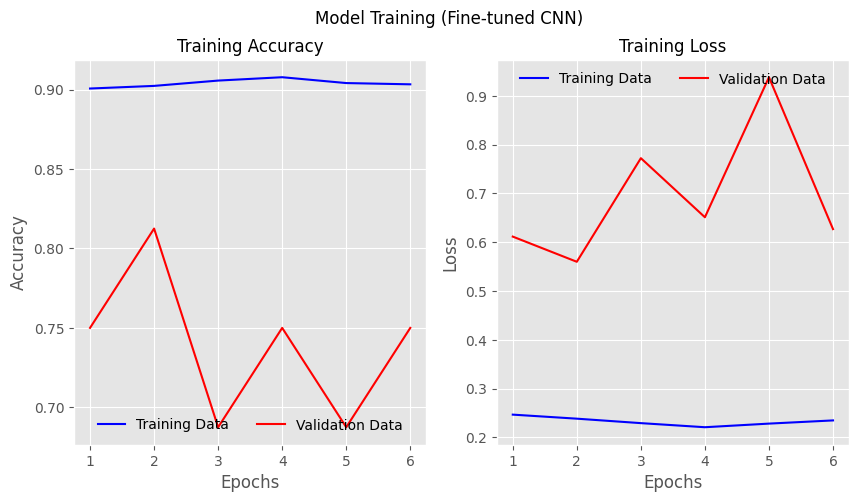

In [82]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/pneumonia_training_finetunedcnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [86]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)


# Evaluating the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.6268
624/624 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.7785 - loss: 0.5669
Validation loss     :0.6268
Validation accuracy :0.7500
Test loss           :0.3723
Test accuracy       :0.8558
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step
              precision    recall  f1-score   support

     healthy       0.96      0.65      0.77       234
    infected       0.82      0.98      0.89       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.86      0.85       624



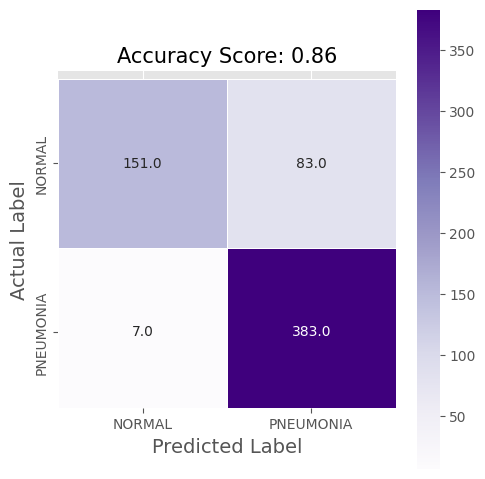

In [87]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

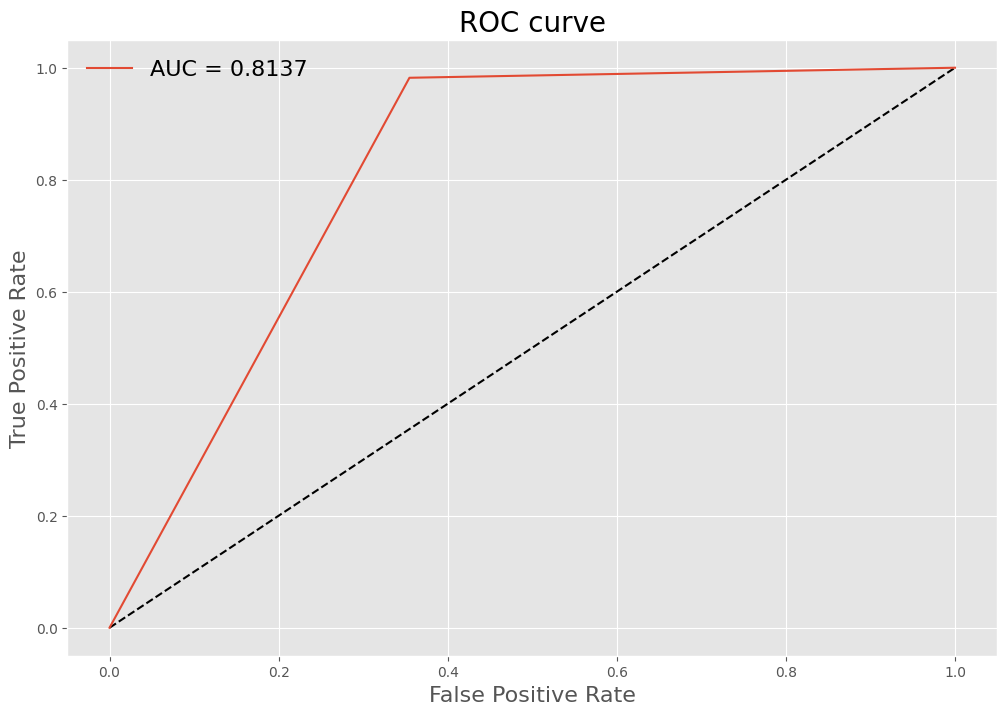

In [88]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

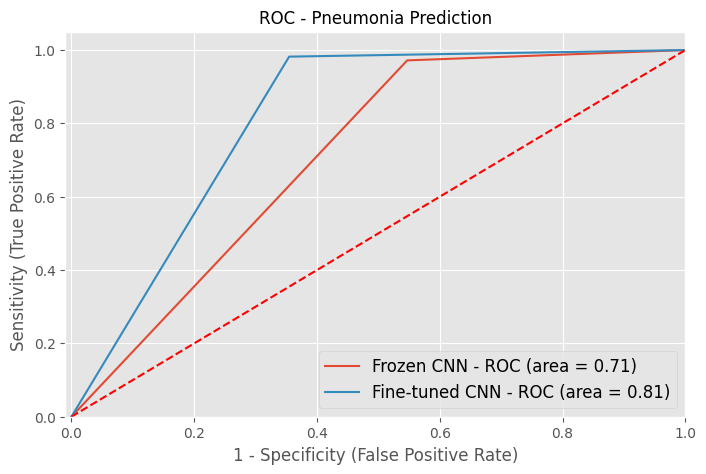

In [89]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']  
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Pneumonia Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("outputs/roc_pneumonia.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[80.13, 91.35]
[75.21, 89.15]


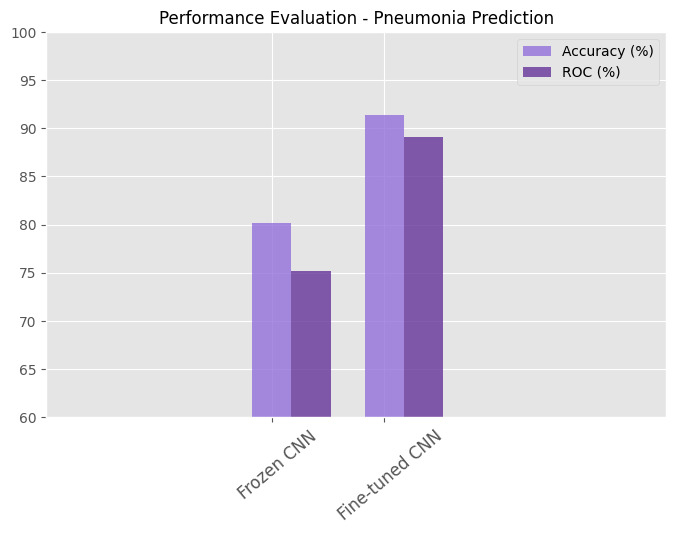

In [90]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

# Test accuracy       :0.8013
# ROC                 :0.7521

# Test accuracy       :0.9135
# ROC                 :0.8915

means_roc = [75.21, 89.15]
means_accuracy = [80.13, 91.35]

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 2
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects2 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity, 
color='mediumpurple',
label='Accuracy (%)')

rects3 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Pneumonia Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("outputs/PE_pneumonia.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[43.31, 30.56]


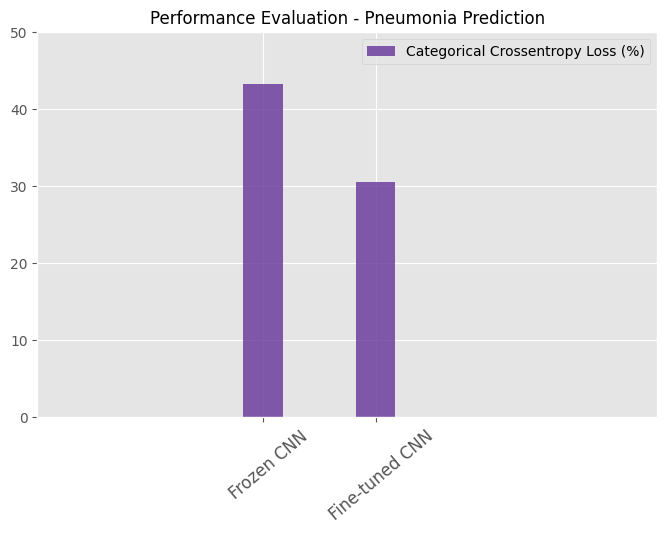

In [91]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

# Test loss           :0.4331
# Test loss           :0.3056

means_loss = [43.31, 30.56]

print(means_loss)

# data to plot
n_groups = 2
means_loss = tuple(means_loss)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_loss, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='Categorical Crossentropy Loss (%)')

plt.xlim([-2, 3.5])
plt.ylim([0, 50])

plt.title('Performance Evaluation - Pneumonia Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("outputs/PE_pneumonia2.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

In [92]:
# Save the trained model
model_03.save("models/pneumonia.h5")

print("Model saved successfully as models/pneumonia.h5")


Model saved successfully as models/pneumonia.h5


# Prediction results for 10 randomly selected images

In [93]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


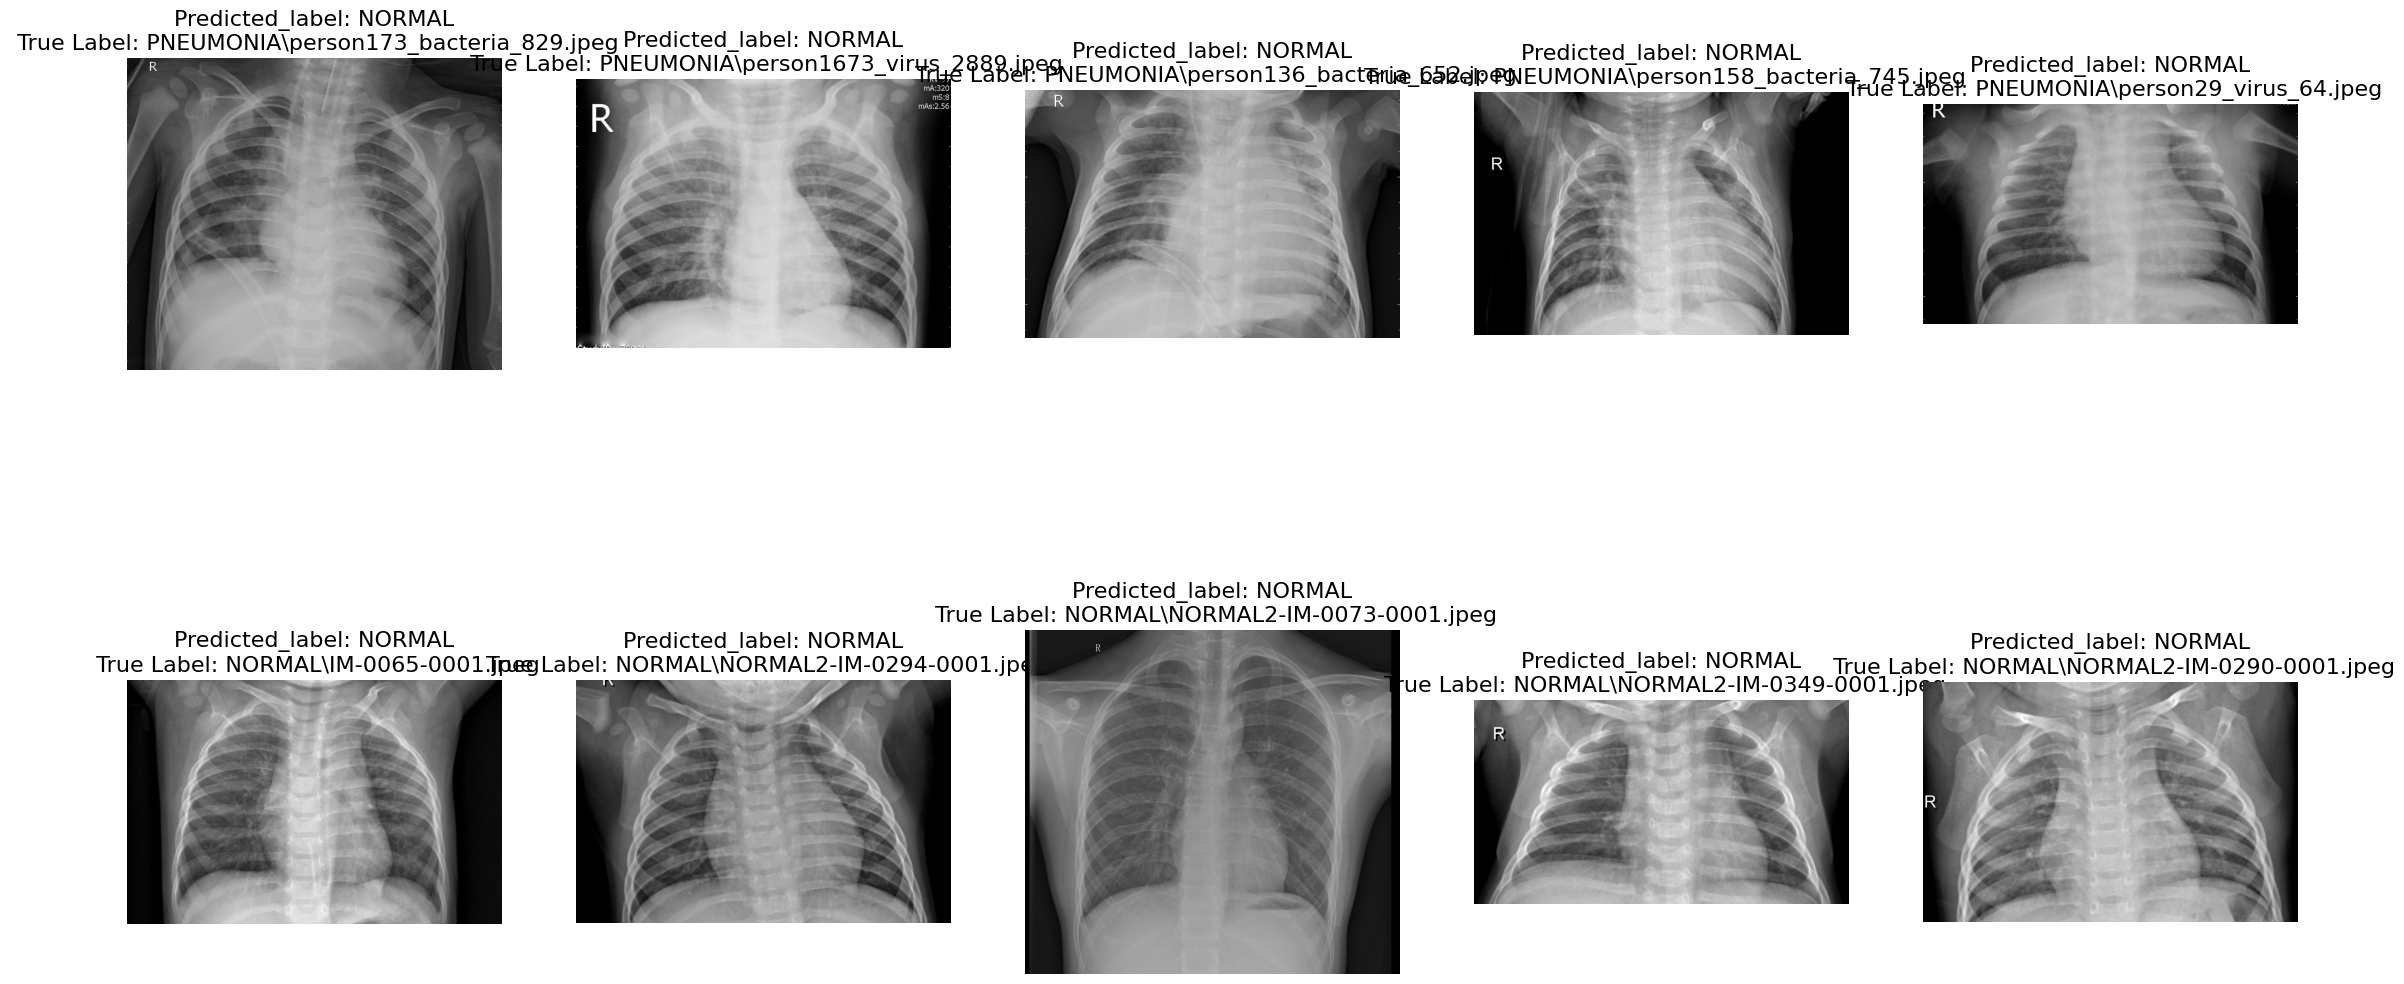

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

true_labels = []
predicted_labels = [] 
fig = plt.figure(figsize=(28,14))
columns=5
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128,128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=16)
plt.savefig("outputs/pneumonia_predictions.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()